In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from fFunc import Ffunc
from gFunc import Gfunc
from modelVelocity import ModelVelocity

In [2]:
def gauss(x, *p):
    A, sigma = p
    return A*np.exp(-x**2/(2.*sigma**2))

In [3]:
#These are the ring parameters.
sigma_Bs = [0.2908075, 0.2908075   , 0.424775  , 0.424775  , 0.424775  , 0.424775 ]
r_ins =    [0.       , 0.2908075   , 0.61265625, 0.816875  , 1.02109375, 1.2253125]
r_outs =   [0.2908075, 0.4846791884, 0.816875  , 1.02109375, 1.2253125 , 1.429531250]

In [4]:
#Initialize the g and f functions. 
f_funcs = [None]*len(r_outs)
for i in range(len(r_ins)):
    f_funcs[i] = Ffunc(sigma_Bs[i], r_ins[i], r_outs[i])
g_func = Gfunc()

In [5]:
flat_samples = np.loadtxt("flat_samples.txt")

In [6]:
#These are the measurements in each ring. 
sigma_obs     = np.array([300,245,191,176,202,191])
sigma_obs_err = np.array([3,21,20,18,18,20])

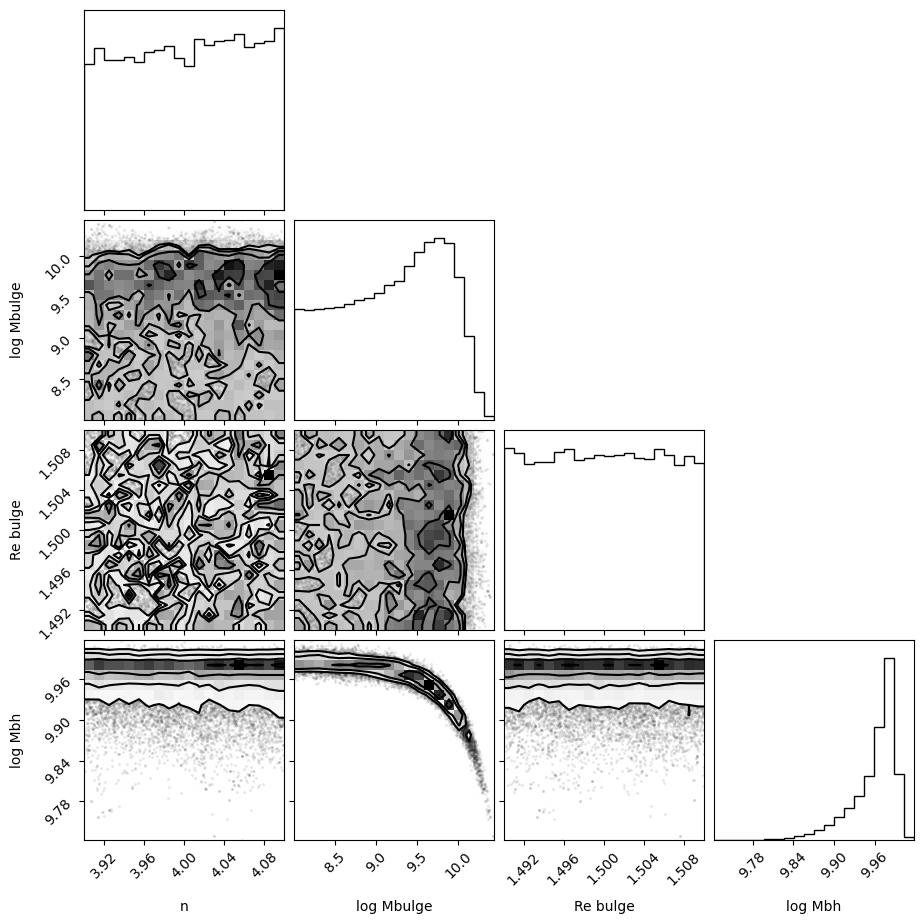

In [7]:
labels = ["n", "log Mbulge", "Re bulge", "log Mbh"]
fig = corner.corner(
    flat_samples, labels=labels
);

In [8]:
n, log_Mbulge, re_bulge, log_Mbh = np.median(flat_samples, axis=0)
Mbulge = 10**log_Mbulge
Mbh = 10**log_Mbh

sigma_model = np.zeros(len(r_ins))
sigma_model_nsm = np.zeros(len(r_ins))
for k in range(len(r_ins)):
    modelv = ModelVelocity(n, Mbulge, re_bulge, Mbh, sigma_Bs[k], r_ins[k], r_outs[k], g_func, f_func=f_funcs[k])

    vs = np.arange(0, 2000, 100)
    Ivs = np.zeros(vs.shape)
    Ivs_nsm = np.zeros(vs.shape)
    for i, v in enumerate(vs):
        #Ivs[i] = modelv.Iv(v)
        Ivs[i] = modelv.Iv_romb(v)
        Ivs_nsm[i] = modelv.Iv_nosmearing(v)
    p0 = [0.1, modelv.sigma(0.5*(r_ins[k]+r_outs[k]))]
    coeffs, _ = curve_fit(gauss, vs, Ivs, p0=p0, check_finite=False)
    sigma_model[k] = coeffs[1]

    coeffs_nsm, _ = curve_fit(gauss, vs, Ivs_nsm, p0=p0, check_finite=False)
    sigma_model_nsm[k] = coeffs_nsm[1]

print(sigma_model)
print(sigma_model_nsm)
print(sigma_obs)
print(sigma_obs_err)

[298.84665512 264.18523644 212.15898019 192.30732117 175.6584616
 162.18628267]
[400.39056986 267.19112386 199.42811407 176.90960247 160.79509703
 148.51714356]
[300 245 191 176 202 191]
[ 3 21 20 18 18 20]


In [12]:
n, log_Mbulge, re_bulge, log_Mbh = np.median(flat_samples, axis=0)
Mbulge = 0. #10**log_Mbulge
Mbh = 10**log_Mbh

sigma_model_nohost = np.zeros(len(r_ins))
for k in range(len(r_ins)):
    modelv = ModelVelocity(n, Mbulge, re_bulge, Mbh, sigma_Bs[k], r_ins[k], r_outs[k], g_func, f_func=f_funcs[k])

    vs = np.arange(0, 2000, 100)
    Ivs = np.zeros(vs.shape)
    for i, v in enumerate(vs):
        Ivs[i] = modelv.Iv_romb(v)
    p0 = [0.1, modelv.sigma(0.5*(r_ins[k]+r_outs[k]))]
    coeffs, _ = curve_fit(gauss, vs, Ivs, p0=p0, check_finite=False)
    sigma_model_nohost[k] = coeffs[1]

print(sigma_model)
print(sigma_model_nohost)
print(sigma_obs)
print(sigma_obs_err)

[298.84665512 264.18523644 212.15898019 192.30732117 175.6584616
 162.18628267]
[294.32799605 259.2291695  206.52820045 186.45309765 169.64216276
 156.0582479 ]
[300 245 191 176 202 191]
[ 3 21 20 18 18 20]


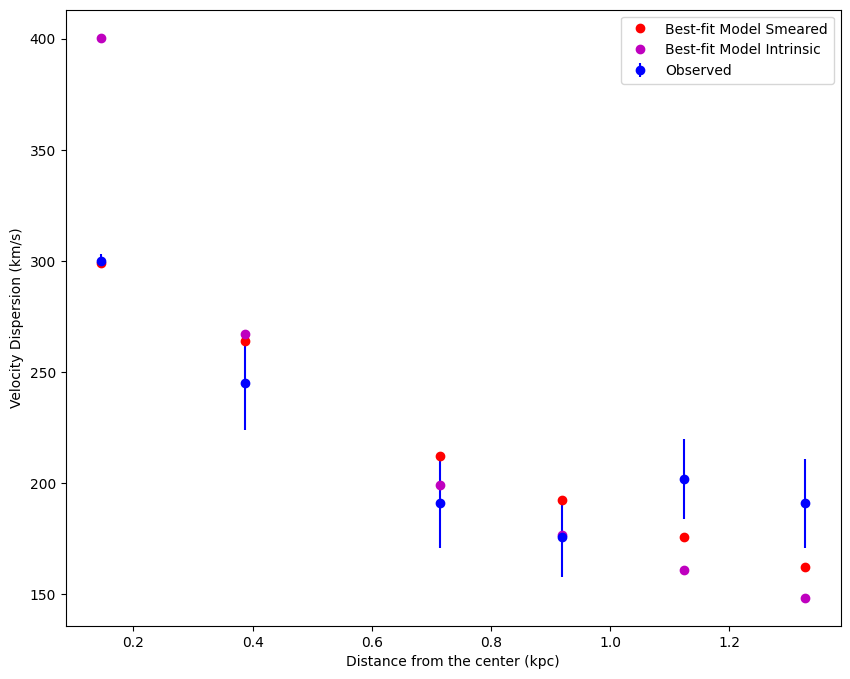

In [11]:
fig, ax = plt.subplots(1, figsize=(10,8))

r_mean = 0.5*(np.array(r_ins)+np.array(r_outs))
ax.errorbar(r_mean, sigma_obs, yerr=sigma_obs_err, fmt='bo', label='Observed')
ax.plot(r_mean, sigma_model, 'ro', label='Best-fit Model Smeared')
ax.plot(r_mean, sigma_model_nsm, 'mo', label='Best-fit Model Intrinsic')
ax.legend()
ax.set_ylabel("Velocity Dispersion (km/s)")
ax.set_xlabel("Distance from the center (kpc)")
plt.show()